In [ ]:
### ARTS as the line-by-line code
import os
# set global variables BEFORE importing ARTS
os.environ['ARTS_DATA_PATH'] = 'path/to/arts-cat-data'

import pyarts
from pyarts import xml
from pyarts.arts import GriddedField4
from pyarts.arts import convert

# the fluxsim module
import FluxSimulator as fsm


# helper packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy as sp
from scipy.constants import speed_of_light as c

import cvxpy as cp

import datadrivenquadrature as ddq
from scipy.sparse import diags

import seaborn as sns


### Intro

This tutorial accompanies <i>Czarnecki and Brath</i>, and will describe how to train a data-driven quadrature (DDQ) scheme, from data generation to a completed set of quadrature points and associated weights. Here we focus on the spectral integration of atmospheric radiation. <br> <br>
The steps to training a DDQ configuration are as follows: <br>
<ol>
  <li>Choosing atmospheric profiles in the form of gas concentrations, temperature, and pressure for training.</li>
  <li>Computing reference line-by-line fluxes and heating rates in these profiles.</li>
  <li>Writing a cost function that will optimize quantities of interest such as fluxes, heating rates, or forcing.</li>
  <li>Perform the simulated annealing optimization.</li>
</ol>	


### Requirements

This tutorial utilizes several existing packages, datasets, and modules:
- `pyarts` version 2.6, available here: https://arts.mi.uni-hamburg.de/getarts/
- the `FluxSimulator` ARTS wrapper module, available here: https://github.com/atmtools/pyarts-fluxes/tree/main
- the `datadrivenquadrature` package, available here: https://github.com/LDEO-CREW/data-driven-quadrature
- their various dependencies. 

### Choosing Atmospheric Profiles
We rely on Robin Hogan's CKDMIP Evaluation1 dataset (available here: https://aux.ecmwf.int/ecpds/home/ckdmip/) to define our training conditions. For specific conditions (e.g., paleoclimate scenarios or exoplanets), these profiles should be carefully chosen to span the range of conditions to be captured by the quadrature scheme. For instance, to train for variability in radiatively active greenhouse gases, we perturb the concentration of the gas in the training dataset by a factor of 8.

### Creating Line-by-Line Training Data

Here I'll compute line-by-line fluxes for the 50 atmospheric profiles included in the present-day Evaluation1 dataset we use in our training dataset. In order to train on single-gas forcing, we also generate 8 $\times$ each individual gas in order to compute the TOA forcing and the error profiles seen in <i>Czarnecki and Brath</i>. <br><br>
We follow the `flux_simulator_single_atm_example.py` available <a href = https://github.com/atmtools/pyarts-fluxes/blob/main/examples/flux_simulator_single_atm_example.py>here</a>. The batch simulator does not return spectral fluxes.<br><br>
We'll start with the longwave fluxes.

In [ ]:
## open example source
concs = xr.open_dataset('/path/to/ckdmip_evaluation1_concentrations_present.nc', engine = "netcdf4").isel(column = np.array([0]), half_level = np.arange(2, 55)).compute() # we select one column; pressure must be > 0.5 Pa

## set wavenumbers at fine spectral discretization
wavenumbers_lw = np.linspace(0.1, 3260, 72000)
frequencies_lw = convert.kaycm2freq(wavenumbers_lw)

surface_reflectivity_lw = 0.0 # nonreflecting surface
# empty; they don't matter for the longwave calculation but are required
geographical_positions_lw = [0, 0]
sun_positions = [1.495978707e11, 0.0, 0.0]


We use the helper function `generate_gridded_field_from_profiles` to process our concentration data into an object usable by ARTS. Note that ARTS requires monotonically decreasing pressure (the first index is the surface) whereas the CKDMIP dataset has them in opposite order. Pressure must be $> 0.5$ hPa and the surface altitude must be the same as the first entry of the altitude array.

In [3]:
# these may be changed to create profiles with gas perturbations. For instance,
# placing 8 in index 0 will produce the same profiles with 8 x CO2
mults = np.array([1, 1, 1, 1, 1, 1]) 

atm_field = fsm.generate_gridded_field_from_profiles(
    concs.pressure_hl.data[0, ::-1].tolist(), # pressure, in units Pa; must be a list
    concs.temperature_hl.data[0, ::-1], # temerpature, in units K
    gases={"H2O": concs.h2o_mole_fraction_hl.data[0, ::-1], 
        "CO2": mults[0]*concs.co2_mole_fraction_hl.data[0, ::-1], 
        "N2": concs.n2_mole_fraction_hl.data[0, ::-1], 
        "O2": concs.o2_mole_fraction_hl.data[0, ::-1], 
        "O3": mults[1]*concs.o3_mole_fraction_hl.data[0, ::-1],
        "CH4": mults[2]*concs.ch4_mole_fraction_hl.data[0, ::-1],
        "N2O": mults[3]*concs.n2o_mole_fraction_hl.data[0, ::-1],
        "CFC11": mults[4]*concs.cfc11_mole_fraction_hl.data[0, ::-1],
        "CFC12": mults[5]*concs.cfc12_mole_fraction_hl.data[0, ::-1]},
    z_field=None 
)

# extract the surface temperature
surface_temperature = concs.temperature_hl.data[0, ::-1][0]
surface_altitude  = atm_field[1][0][0][0]

Next we use the `FluxSimulator` module to do the line-by-line calculations. This will take some time, especially the first time, when the lookup table for the setup is calculated; the lookup table for a fine spectral discretization will be large. It should be saved in its own folder, then that folder can be accessed by setting the path in line 2.

In [ ]:
FluxSimulator_LW = fsm.FluxSimulator("lw")
FluxSimulator_LW.set_paths(lut_path='/../path/to/lut/lw') #set path to existing LUT

# set the wavenumber grid
FluxSimulator_LW.ws.f_grid = frequencies_lw

# set the gas species
# here we include water vapor with its continua, CO2, ozone, O2 with its collision-induced absorption (CIA), CH4, N2O, N2
# with its CIA, and CFC-11 and -12, which are cross-section variables. Data for these can be found in the ARTS catalogue
FluxSimulator_LW.set_species(
    [
       "O2, O2-CIAfunCKDMT100",
        "H2O, H2O-SelfContCKDMT400, H2O-ForeignContCKDMT400",
        "O3",
        "CO2, CO2-CKDMT252",
        "N2, N2-CIAfunCKDMT252, N2-CIArotCKDMT252",
        "N2O",
        "CH4", 
        "CFC11-XFIT", "CFC12-XFIT"
    ]
)

Skipping download, environment variable ARTS_DATA_PATH already set.


With the flux simulator set up, we can now calculate the fluxes.

In [5]:
results_lw = FluxSimulator_LW.flux_simulator_single_profile(
    atm_field,
    surface_temperature,
    surface_altitude,
    surface_reflectivity_lw,
    geographical_positions_lw,
)

setting up absorption...

...using stored LUT

starting calculation...



Start disort


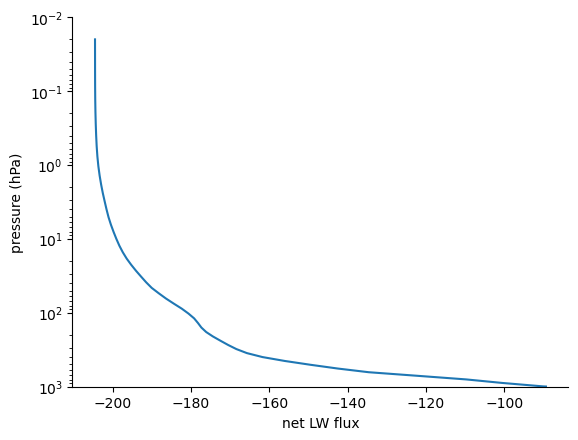

In [20]:
plt.semilogy(np.abs(results_lw["flux_clearsky_down"]) - np.abs(results_lw["flux_clearsky_up"]), results_lw["pressure"]/100)
plt.xlabel("net LW flux")
plt.ylabel("pressure (hPa)")
sns.despine()
plt.ylim([10**3, 10**-2])
plt.show()


The shortwave calculation is similar, except we must define the solar zenith angle. This can be done by setting the latitude according to the zenith angle if the sun were overhead on the equator.

In [ ]:
## open example source
concs = xr.open_dataset('/path/to/ckdmip_evaluation1_concentrations_present.nc', engine = "netcdf4").isel(column = np.array([0]), half_level = np.arange(2, 55)).compute() # we select one column; pressure must be > 0.5 Pa

## set wavenumbers at fine spectral discretization
wavenumbers_sw = np.linspace(2000, 50000, 62530)
frequencies_sw = convert.kaycm2freq(wavenumbers_sw)

surface_reflectivity_sw = 0.3 # nonreflecting surface

# mu = cos(theta) where theta is the solar zenith angle
mu = 0.3
geographical_positions_sw = [(180/np.pi)*np.arccos(mu), 0]
sun_positions = [1.495978707e11, 0.0, 0.0] # keep sun overhead at equator


The atmosphere may be set up in the same way. As the CFCs have negligible impact in the shortwave, we won't train on their perturbation.

In [23]:
# these may be changed to create profiles with gas perturbations. For instance,
# placing 8 in index 0 will produce the same profiles with 8 x CO2
mults = np.array([1, 1, 1, 1]) 

atm_field = fsm.generate_gridded_field_from_profiles(
    concs.pressure_hl.data[0, ::-1].tolist(), # pressure, in units Pa; must be a list
    concs.temperature_hl.data[0, ::-1], # temerpature, in units K
    gases={"H2O": concs.h2o_mole_fraction_hl.data[0, ::-1], 
        "CO2": mults[0]*concs.co2_mole_fraction_hl.data[0, ::-1], 
        "N2": concs.n2_mole_fraction_hl.data[0, ::-1], 
        "O2": concs.o2_mole_fraction_hl.data[0, ::-1], 
        "O3": mults[1]*concs.o3_mole_fraction_hl.data[0, ::-1],
        "CH4": mults[2]*concs.ch4_mole_fraction_hl.data[0, ::-1],
        "N2O": mults[3]*concs.n2o_mole_fraction_hl.data[0, ::-1],
        "CFC11": concs.cfc11_mole_fraction_hl.data[0, ::-1],
        "CFC12": concs.cfc12_mole_fraction_hl.data[0, ::-1]},
    z_field=None 
)

# extract the surface temperature
surface_temperature = concs.temperature_hl.data[0, ::-1][0]
surface_altitude  = atm_field[1][0][0][0]

Similarly, we set up the shortwave simulator. Note that the ozone cross-sections are very important to the shortwave calculation and should not be omitted.

In [ ]:
FluxSimulator_SW = fsm.FluxSimulator("sw")
FluxSimulator_SW.set_paths(lut_path='/../path/to/lut/sw') #set path to existing LUT

# set the wavenumber grid
FluxSimulator_SW.ws.f_grid = frequencies_sw

# set the gas species
# here we include water vapor with its continua, CO2, ozone, O2 with its collision-induced absorption (CIA), CH4, N2O, N2
# with its CIA, and CFC-11 and -12, which are cross-section variables. Data for these can be found in the ARTS catalogue
FluxSimulator_SW.set_species(
    ["H2O, H2O-SelfContCKDMT400, H2O-ForeignContCKDMT400",
        "O2-*-1e12-1e99,O2-CIAfunCKDMT100",
        "N2, N2-CIAfunCKDMT252, N2-CIArotCKDMT252",
        "CH4",
        "CO2, CO2-CKDMT252",
        "N2O",
        "O3",
        "O3-XFIT",    
        ]
)

FluxSimulator_SW.emission = 0 # shortwave emission is 0
FluxSimulator_SW.gas_scattering = True # we want to include gas scattering
FluxSimulator_SW.set_sun(sun_positions) 


Skipping download, environment variable ARTS_DATA_PATH already set.


In [32]:
results_sw = FluxSimulator_SW.flux_simulator_single_profile(
    atm_field,
    surface_temperature,
    surface_altitude,
    surface_reflectivity_sw,
    geographical_positions_sw,
)

setting up absorption...

...using stored LUT

starting calculation...



Start disort


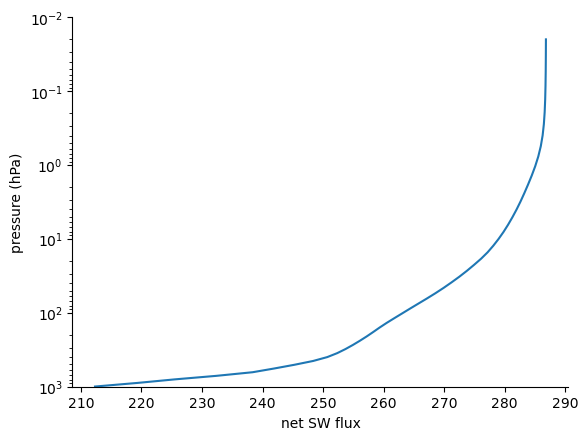

In [33]:
plt.semilogy(np.abs(results_sw["flux_clearsky_down"]) - np.abs(results_sw["flux_clearsky_up"]), results_sw["pressure"]/100)
plt.xlabel("net SW flux")
plt.ylabel("pressure (hPa)")
sns.despine()
plt.ylim([10**3, 10**-2])
plt.show()


### Cost Functions
If the atmospheric profiles span the range of atmospheric conditions, the cost function should encode which quantities should be learned (e.g., fluxes, heating rates, forcing). <br> <br>
First, we write a helper function to construct the second-order accurate, first derivative matrix to calculate heating rates. `np.gradient` is incompatible with the `cvxpy` optimization package.

In [2]:
N_LEVELS = 53 # set this to the number of vertical levels. In this example it is 53

def derivative_matrix(nx):
    """
    Constructs the centered second-order accurate first-order derivative, equivalent to np.gradient
    """
    diagonals = [[-1./2.], [0], [1./2.]] # main diagonal elements
    offsets = [-1, 0, 1] # positions of the diagonal entries relative to the main diagonal

    # Call to the diags routine; note that diags returns a *representation* of the array;
    # to explicitly obtain its ndarray realisation, the call to .toarray() is needed.
    d1mat = diags(diagonals, offsets, shape=(nx,nx)).toarray()

    # We replace the first and last lines of d1mat with the proper
    # one-sided finite differences
    d1mat[0, :2] = np.array([-1, 1]) # first line
    d1mat[-1, -2:] = np.array([1, -1]) # last line

    # Return the final array divided by the grid spacing
    return d1mat

mat = derivative_matrix(N_LEVELS) 

We first demonstrate a general cost function, compatible with the DDQ package, that is the sum of the root mean squared error of the vertical flux profile, the vertical heating rate profile, and the top-of-the-atmosphere radiative forcing of 6 major greenhouse gases at 8 $\times$ present-day values. <br><br>
The cost function is in the general form 
$$
    C =  f_0 \lVert F_{est} - F_{ref}\rVert +  f_1\lVert H_{est} - H_{ref} \rVert + \sum_i f_i \lVert \mathcal{F}^i_{est} - \mathcal{F}^i_{ref} \lVert.
$$
$f_0 = 0.15$ and acts on the flux RMS; $f_1 = 1$ acts on the heating rate RMS; $f_2 ... f_7$ act on the RMS of forcing by $\mathrm{CO}_2$, $\mathrm{CH}_4$, $\mathrm{N}_2\mathrm{O}$, $\mathrm{O}_3$, CFC-11 and CFC-12, in that order. <br><br>
In the shortwave, we must additionally capture variability in the cosine of solar zenith angle ($\mu_0$) and surface reflectivity ($R$). In order to capture this variability, we generate training profiles across a combination of parameters ($\mu_0, R$) and randomly choose one such tuple for each training profile at each iteration of the optimization. We have done this for 5 different $\mu_0$ and $R$ each, producing 25 different possible configurations for each atmospheric profile. <br><br>
A pair of hyperparameters determines whether the below cost function is the shortwave or longwave cost function:
- In order to train a specific subset of radiative quantities, the user may set the coefficient preceding each term via `F_ARRAY`.
    - e.g., to train only present day variability, $f_2 ... f_7$ should be set to 0 to exclude forcing from the calculation
    - in the shortwave, $f_6$ and $f_7$ should be set to 0 to exclude CFC-11 and -12

- The user may choose how many 'scenarios', or random condition tuples, to sample across the given base profiles via `N_SCENARIOS`.
    - in the longwave, we don't sample solar/surface variability, so we choose `N_SCENARIOS = 1`. 
    - in the shortwave, we want `N_SCENARIOS` $= |\mu_0| \times |R|$. Here we choose from 5 $\mu_0$ and 5 $R$, so `N_SCENARIOS = 25`.

In [3]:
# hyperparameters for the shortwave, including all forcings:
N_SCENARIOS = 25
F_ARRAY = np.array([0.15, 1, 1, 1, 1, 1, 0, 0])

In [4]:
# hyperparameters for the longwave, including all forcings:
N_SCENARIOS = 1
F_ARRAY = np.array([0.15, 1, 1, 1, 1, 1, 1, 1])

In [4]:
N_COLS = 49 # set the number of columns

In [ ]:
def cost_function(y_hat, y_ref, x_sup):
    """
    In: 
        y_hat: estimate; flattened array of (rows*scenarios*cols + gases*cols) shape, 
            where the last columns are forcings
            The order of the forcings should match that in the map function
            Here we're using CO2, CH4, N2O, O3, CFC11, CFC12
        y_ref: reference values/data 
        x_sup: supplementary data, here, heating rates and pressures.
    Out:
        cost_function: the value of the cost function
    """
    
    if isinstance(y_hat, xr.Dataset):
        # dummy return for checks 
        return cp.norm(y_ref.reference_forcing_co2.data - y_hat.reference_forcing_co2.data)
    
    # constants
    g = 9.81 # gravity (m/s^2)
    scaling = 3600*24 # heating rate conversion factor: seconds * minutes * hours in a day 

    ## choose columns with random variability in zenith angle, reflectivity.
    scenario_cols = np.random.randint(0, N_SCENARIOS, N_COLS, dtype = int) + N_SCENARIOS*np.arange(N_COLS)

    # constants for indexing through the flattened array
    end_fluxes_idx = N_LEVELS*N_COLS*N_SCENARIOS
    end_co2_idx = end_fluxes_idx + N_COLS*N_SCENARIOS
    end_ch4_idx = end_co2_idx + N_COLS*N_SCENARIOS
    end_n2o_idx = end_ch4_idx + N_COLS*N_SCENARIOS
    end_o3_idx = end_n2o_idx + N_COLS*N_SCENARIOS
    end_cfc11_idx = end_o3_idx + N_COLS*N_SCENARIOS

    # separate flux columns
    F_est = y_hat[:end_fluxes_idx]
    F_est = cp.reshape(F_est, [N_COLS*N_SCENARIOS, N_LEVELS], 'F')[scenario_cols, :]
    F_est = cp.reshape(F_est, [N_COLS*N_LEVELS], 'F')


    # separate forcing columns
    Force_est_co2 = y_hat[end_fluxes_idx:end_co2_idx]
    Force_est_co2 = Force_est_co2[scenario_cols]

    Force_est_ch4 = y_hat[end_co2_idx:end_ch4_idx]
    Force_est_ch4 = Force_est_ch4[scenario_cols]

    Force_est_n2o = y_hat[end_ch4_idx:end_n2o_idx]
    Force_est_n2o = Force_est_n2o[scenario_cols]

    Force_est_o3 = y_hat[end_n2o_idx:end_o3_idx]
    Force_est_o3 = Force_est_o3[scenario_cols]

    Force_est_cfc11 = y_hat[end_o3_idx:end_cfc11_idx]
    Force_est_cfc11 = Force_est_cfc11[scenario_cols]

    Force_est_cfc12 = y_hat[end_cfc11_idx:]
    Force_est_cfc12 = Force_est_cfc12[scenario_cols]

    # choose scenario subset in reference data
    y_ref = y_ref.isel(column = scenario_cols)
    x_sup = x_sup.isel(column = scenario_cols)

    # L2 norm of estimated flux error
    F_err = cp.norm((F_est - y_ref.reference_fluxes.data.reshape(-1)))

    # compute estimated heating rate from estimated fluxes
    H_est = -scaling*(cp.matmul(mat, cp.reshape(F_est, [N_COLS, N_LEVELS], 'F').T)*g)/cp.matmul(mat, x_sup.pressures.data.T)/1004

    # L2 norm of estimated heating rate error
    H_err = cp.norm((H_est.T-x_sup.reference_heating))

    # L2 norms of forcing estimates
    Force_err_co2 = cp.norm((Force_est_co2 - y_ref.reference_forcing_co2.data.reshape(-1)))
    Force_err_co2 = cp.norm((Force_est_co2 - y_ref.reference_forcing_co2.data.reshape(-1)))

    Force_err_ch4 = cp.norm((Force_est_ch4 - y_ref.reference_forcing_ch4.data.reshape(-1)))
    Force_err_ch4 = cp.norm((Force_est_ch4 - y_ref.reference_forcing_ch4.data.reshape(-1)))

    Force_err_n2o = cp.norm((Force_est_n2o - y_ref.reference_forcing_n2o.data.reshape(-1)))
    Force_err_n2o = cp.norm((Force_est_n2o - y_ref.reference_forcing_n2o.data.reshape(-1)))

    Force_err_o3 = cp.norm((Force_est_o3 - y_ref.reference_forcing_o3.data.reshape(-1)))
    Force_err_o3 = cp.norm((Force_est_o3 - y_ref.reference_forcing_o3.data.reshape(-1)))

    Force_err_cfc11 = cp.norm((Force_est_cfc11 - y_ref.reference_forcing_cfc11.data.reshape(-1)))
    Force_err_cfc11 = cp.norm((Force_est_cfc11 - y_ref.reference_forcing_cfc11.data.reshape(-1)))

    Force_err_cfc12 = cp.norm((Force_est_cfc12 - y_ref.reference_forcing_cfc12.data.reshape(-1)))
    Force_err_cfc12 = cp.norm((Force_est_cfc12 - y_ref.reference_forcing_cfc12.data.reshape(-1)))


    cost_function = F_ARRAY[0]*F_err + F_ARRAY[1]*H_err + F_ARRAY[2]*Force_err_co2 + F_ARRAY[3]*Force_err_ch4 + F_ARRAY[4]*Force_err_n2o + F_ARRAY[5]*Force_err_o3 + F_ARRAY[6]*Force_err_cfc11 + F_ARRAY[7]*Force_err_cfc12

    return cost_function


### Optimization
One can use the package `datadrivenquadrature` to perform the simulated annealing optimization. First we wrangle the data into xarrays with the following structure:

- `x_data`: spectral fluxes and spectral forcing for each vertical pressure level, "horizontal" atmospheric column, and spectral coordinate. It is required that the last dimension is the integration axis; otherwise, the horizontal and vertical structure is arbitrary, though it should match across the input datasets. <br><br>
Each quantity will be normalized being passed into `ddq.optimize`. <br><br>
If working with training data in the form of an `xarray`, the shape of the array ([the number of vertical levels + the number of single-gas forcings] $\times$ the number of atmospheric profiles) should be set as a coordinate to pass the package's input checks. If working with numpy arrays this may be skipped.

Here's a sample of how `x_data` may look. The details will depend on how you saved your training profiles. If you're omitting any of the forcings, these quantities should be filled in as zeros, or you may edit the map and cost functions.

In [ ]:
x_data =  xr.Dataset(
    data_vars = dict(
        spectral_fluxes = (["pressure", "profile", "spectral_coord"], spectral_fluxes),
        spectral_forcing_co2 = (["profile", "spectral_coord"], spectral_forcing_co2),
        spectral_forcing_ch4 = (["profile", "spectral_coord"], spectral_forcing_ch4),
        spectral_forcing_n2o = (["profile", "spectral_coord"], spectral_forcing_n2o),
        spectral_forcing_o3 = (["profile", "spectral_coord"], spectral_forcing_o3),
        spectral_forcing_cfc11 = (["profile", "spectral_coord"], spectral_forcing_cfc11),
        spectral_forcing_cfc12 = (["profile", "spectral_coord"], spectral_forcing_cfc12),

    ),
    coords = dict(
        pressure = pressure,
        profile = profile,
        spectral_coord = spectral_coord,
        shape = np.array([len(pressure)*len(profile) + 6*len(profile)]),
    ),
)


Once `x_data` is set up we calculate the normalization vector, since our training reference values must be normalized by the width of the integration axis.

In [6]:
# calculate the scale to use for integration axis normalization
norm_vector = ddq.find_normalization_vector(x_data, ['spectral_coord'])[0][0]

- `y_ref_data`: the accompanying integrated quantities (fluxes and forcing), with the same shapes as `x_ref_data`. <br> <br>
These quantities will likewise be normalized within `ddq.optimize`, and again we set the size of the array as an attribute.

In [ ]:
y_ref_data =  xr.Dataset(
    data_vars = dict(
        reference_fluxes = (["pressure", "profile"], reference_fluxes/norm_vector),
        reference_forcing_co2 = (["profile"], reference_forcing_co2/norm_vector),
        reference_forcing_ch4 = (["profile"], reference_forcing_ch4/norm_vector),
        reference_forcing_n2o = (["profile"], reference_forcing_n2o/norm_vector),
        reference_forcing_o3 = (["profile"], reference_forcing_o3/norm_vector),
        reference_forcing_cfc11 = (["profile"], reference_forcing_cfc11/norm_vector),
        reference_forcing_cfc12 = (["profile"], reference_forcing_cfc12/norm_vector),
    ),
    coords = dict(
        pressure = pressure,
        profile = profile,
        spectral_coord = spectral_coord,
        shape = np.array([len(pressure)*len(profile) + 6*len(profile)]),
    ),
)


- `x_sup_data`: supplementary training data for the cost function, in the same horizontal/vertical shape as above. Here we normalize the reference heating data, as it will be compared to heating rates derived from normalized fluxes. Pressures will be used to compute heating rates, and are not normalized.

In [ ]:
x_sup_data = xr.Dataset(
    data_vars = dict(reference_heating = (["profile", "pressure"], reference_heating/norm_vector),
        pressures = (["profile", "pressure"], pressures),),
    coords = dict(
        pressure = pressure,
        profile = profile,
        spectral_coord = spectral_coord, 
        shape = np.array([len(pressure)*len(profile) + 6*len(profile)]),),
)

- `map_func`: a supplementary function that tells `datadrivenquadrature` how to interact with the spectral training data. Since we are working with `xarray` the mapping function is simply `xarray`'s isel. <br><br>
We must pre-set the number of spectral points. In <i>Czarnecki and Brath</i> we use 64.

In [9]:
N_INTEGRATION_POINTS = 64

def map_func(x, point_set):
    # select the spectral points
    subset = x.isel(spectral_coord = point_set)

    # flatten the spectral fluxes. Modify this line if not including all forcings in dataset.
    subset = np.concatenate((subset.spectral_fluxes.data.reshape(N_COLS*N_LEVELS*N_SCENARIOS, N_INTEGRATION_POINTS), subset.spectral_forcing_co2.data, subset.spectral_forcing_ch4.data, subset.spectral_forcing_n2o.data, subset.spectral_forcing_o3.data, subset.spectral_forcing_cfc11.data, subset.spectral_forcing_cfc12.data), axis = 0)   
    
    return subset

Finally we set up optimization hyperparameters. These are the hyperparameters we use in the paper.

In [ ]:
params = {}
integration_list = ['spectral_coord'] # we call our wavenumber/frequency/wavelength axis 'spectral_coord'
params['integration_list'] = integration_list
params['n_points'] = N_INTEGRATION_POINTS
params['epochs'] = 700 # how many epochs to perform 
params['success'] = 100 # how many successful moves to require in a block
params['block_size'] = 500 # how many possible moves in an epoch
params['random_seed'] = 1 # for debugging
params['verbose'] = 3
params['solver'] = 'SCS'

Then we pass our training data, cost function, mapping function, hyperparameters, and supplementary data into `optimize` function of `datadrivenquadrature`. This function will perform the optimization and return a dictionary object including the sampled spectral points, the associated weights, the cost function value, the annealing temperature, and the index of the best-seen state.

In [ ]:
history = ddq.optimize(x_data, y_ref_data, cost_function, map_func, params, x_sup = x_sup_data)